# Basics of Machine Learning `part 2`

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Table of Contents
<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->

- [Realworld dataset](#realworld_dataset)
- [Performance metrics in classification](#perf_metrics)
- [Model selection](#model_selection)
- [Exercice](#exerc)

The goal of `part 2` is to provide more metrics and systematic methods to test and compare machine learning techniques in the specific task of classification. To do so, we propose to work with a realworld dataset provided within the `sklearn` library. We present additional metrics, beyond classification accuracy. Then we present how these metrics, together with cross-validation methodology, allows for model selection. 

<a name="realworld_dataset"></a>
# Realworld dataset

In [1]:
import random
import numpy as np
import warnings
warnings.filterwarnings('ignore') 

from basics.utils import reduce_dataset

We consider here a more complex dataset, stemming from "real-world" data: the **covtype** dataset provided within sklearn. From the sklearn user guide (https://scikit-learn.org/stable/datasets/index.html#covtype-dataset): 
> The samples in this dataset correspond to 30×30m patches of forest in the US, collected for the task of predicting each patch’s cover type, i.e. the dominant species of tree. There are seven covertypes, making this a multiclass classification problem. Each sample has 54 features, described on the dataset’s homepage. Some of the features are boolean indicators, while others are discrete or continuous measurements.

Characteristics:

  | Element | value |
  |---------|---|
  | Classes | 7 |
  | Samples total |	581012 |
  | Dimensionality |	54 |
  | Features | int |
  
 Example of instance: ![](https://archive.ics.uci.edu/ml/assets/MLimages/Large31.jpg)
 
Dataset website: https://archive.ics.uci.edu/ml/datasets/Covertype

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
from sklearn import datasets
dataset = datasets.fetch_covtype()

In [5]:
print(dataset.data.shape)

(581012, 54)


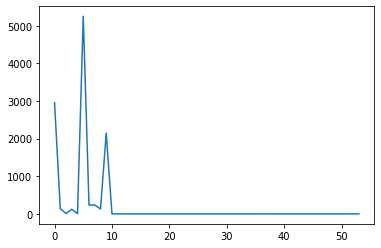

In [8]:
plt.plot(dataset.data[1001])

In [9]:
print(np.unique(dataset.target))

[1 2 3 4 5 6 7]


In [10]:
features = dataset.data
labels = dataset.target

We will select a subset of the dataset in order to be able to have immediate results

In [11]:
[features, labels] = reduce_dataset(features, labels, num_obs=1660)

In [12]:
print(features.shape)
print(labels.shape)

(11620, 54)
(11620,)


<a name="perf_metrics"></a>
# Performance metrics in classification

## Accuracy

We have already mentioned that accuracy is a widely metrics to assess the performance of a model. It counts the number of good predictions among all the predictions

Let us inspect accuracy on the dataset considered. We first split the dataset into a training set and a testing set.

In [13]:
import random

In [14]:
indexes = np.arange(len(features.data))
print(indexes)

[    0     1     2 ... 11617 11618 11619]


In [15]:
random.shuffle(indexes)
print(indexes)

[10840  4067  7715 ...  9847   482 10961]


Shuffled dataset:

In [16]:
X = features[indexes]
Y = labels[indexes]

Now we can split between **training set** and **testing set**

In [17]:
train_X = X[:int(0.8 * len(X))]
train_Y = Y[:int(0.8 * len(Y))]

In [18]:
test_X = X[int(0.8 * len(X)):]
test_Y = Y[int(0.8 * len(Y)):]

Inspect total sizes:

In [19]:
print(train_X.shape)
print(test_X.shape)

(9296, 54)
(2324, 54)


Let's get a classifier of our choice (e.g. kNN)

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
clf = KNeighborsClassifier()

In [22]:
clf.fit(train_X, train_Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [23]:
accuracy = clf.score(test_X, test_Y)
print('accuracy =', accuracy)

accuracy = 0.7753872633390706


**QUESTION: what does it mean?**

## Confusion matrix

It's good to have a statistics on the number of good answers our classifier is able to predict, but if we want to understand its behaviour we need more information. 

A very common metric is to inspect the confusion the classifier is making between classes, it's what we called confusion matrix: it is counting the number of times an instance from class `i` has been predicted as class `j` where `j` can be `i` or another one. 

<img src='./assets/confusion_matrix.png' style="width:80%"></img>

In [24]:
pred_Y = clf.predict(test_X)

In [25]:
print(pred_Y)

[5 7 5 ... 6 7 7]


### Computing the confusion matrix "manually"

In [26]:
classes = np.unique(test_Y)
num_classes = len(classes)
print(num_classes, classes)

7 [1 2 3 4 5 6 7]


In [27]:
confmat = np.zeros((num_classes, num_classes))
for obs_i in range(len(test_X)):
    pred_Y_i = clf.predict([test_X[obs_i]])
    confmat[test_Y[obs_i] - 1, pred_Y_i - 1] += 1

In [28]:
confmat

array([[227.,  66.,   1.,   0.,  12.,   0.,  55.],
       [ 87., 160.,  18.,   0.,  37.,  11.,   7.],
       [  0.,   6., 224.,  27.,   8.,  58.,   0.],
       [  0.,   0.,  13., 315.,   0.,   6.,   0.],
       [  1.,   7.,   7.,   0., 305.,   5.,   0.],
       [  0.,   3.,  43.,  18.,   6., 266.,   0.],
       [ 17.,   3.,   0.,   0.,   0.,   0., 305.]])

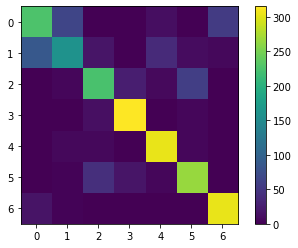

In [29]:
plt.imshow(confmat)
plt.colorbar()

### Using sklearn

Sklearn provides a method for computing confusion matrices, see dedicated page: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [30]:
from sklearn.metrics import confusion_matrix

In [31]:
pred_Y = clf.predict(test_X)

In [32]:
confmat = confusion_matrix(test_Y, pred_Y)

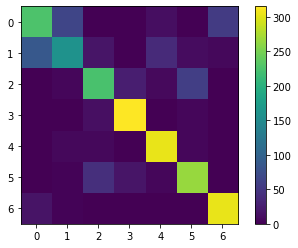

In [33]:
plt.imshow(confmat)
plt.colorbar()

## Additional important metrics

### Notion of true positives and co.

We differentiate between true positives, true negatives, false positives and false negatives.

Definitions. Let consider the case where we have to classify ann image `I` as either a `cat`, a `dog`, or a `donkey`. We first consider the class `cat`:
- **True Positives (TPs)**: we know that an image `I` belongs to class `cat`, and it has been rightly labelled `cat` by the classifier
- **True Negatives (TNs)**: we know that an observation `I` does not belong to class `cat` (in our exemple, it can belong to class `dog` or `donkey`, we don't really care) and it has not been labelled `cat` by the classifier
- **False Positives (TPs)**: we know that an observation `I` does not belong to class `cat` (it belongs to class `dog` or `donkey`), and it has been wrongly labelled `cat` by the classifier
- **False Negatives (TNs)**: we know that an observation `I` belongs to class `cat` and it has not been labelled `cat` by the classifier.

From these categories, we can compute two useful measures: **Precision** and **Recall**. By taking the exemple above:
- Precision is the proportion of images rightly categorized as `cat` among all the instances categorized as a `cat`
- Recall is the proportion of images rightly categorized as `cat` among all instances that should have been categorized as `cat`

From Wikipedia:

<img src="./assets/precisionrecall.png" style="width:30%"></img>

A widely used measure taking into account Precision and Recall is the **F1 Score**:

$$fscore = 2*\frac{precision \times recall}{precision + recall}$$

### Computations

In [34]:
from sklearn.metrics import precision_recall_fscore_support

In [35]:
[precision, recall, _, _] = precision_recall_fscore_support(test_Y, pred_Y)

In [36]:
precision

array([0.68373494, 0.65306122, 0.73202614, 0.875     , 0.82880435,
       0.76878613, 0.83106267])

In [37]:
recall

array([0.62880886, 0.5       , 0.69349845, 0.94311377, 0.93846154,
       0.79166667, 0.93846154])

Average globally

In [38]:
[precision, recall, _, _] = precision_recall_fscore_support(test_Y, pred_Y, average='macro')

In [39]:
fscore = 2 * (precision * recall) / (precision + recall)

In [40]:
print(precision)
print(recall)
print(fscore)

0.7674964933333036
0.7762872617604495
0.7718668489088678


Looks like the accuracy?....

### Imbalance dataset

So far we made a strong constraint on our datasets : **each class has the same number of observations!**. This is not realistic in real world cases. 

Let's inspect what happens in case of datasets with different number of instance per class. We take the original data, this time we reduce the whole dataset by keeping a certain percentage of the observations per class, and not a fixed number of them. 

In [41]:
features = dataset.data
labels = dataset.target
[features, labels] = reduce_dataset(features, labels, reduce_by=98)

In [42]:
print(features.shape)

(11617, 54)


As before, we shuffle and build the training and testing sets:

In [44]:
indexes = np.arange(len(features.data))
random.shuffle(indexes)

In [45]:
X = features[indexes]
Y = labels[indexes]

In [46]:
train_X = X[:int(0.8 * len(X))]
train_Y = Y[:int(0.8 * len(Y))]

In [47]:
test_X = X[int(0.8 * len(X)):]
test_Y = Y[int(0.8 * len(Y)):]

Inspect number of instances per class:

In [48]:
for c in np.unique(labels):
    idx_train = np.where(train_Y == c)[0]
    idx_test = np.where(test_Y == c)[0]
    print('class', c, '\t num. training obs', len(idx_train), ' | num. testing obs', len(idx_test))

class 1 	 num. training obs 3385  | num. testing obs 851
class 2 	 num. training obs 4557  | num. testing obs 1109
class 3 	 num. training obs 569  | num. testing obs 146
class 4 	 num. training obs 41  | num. testing obs 13
class 5 	 num. training obs 138  | num. testing obs 51
class 6 	 num. training obs 274  | num. testing obs 73
class 7 	 num. training obs 329  | num. testing obs 81


In [49]:
clf = KNeighborsClassifier()

In [50]:
clf.fit(train_X, train_Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [51]:
accuracy = clf.score(test_X, test_Y)
print('accuracy =', accuracy)

accuracy = 0.8648881239242685


**QUESTIONS:** 
- Do we have a better classifier than before? 
- What does this score mean?

<img src="assets/exerice-icon.png" style="width:80px; float:left;"></img><div style="clear:left;"></div>
**EXERCICE:** plot the confusion matrix and comment

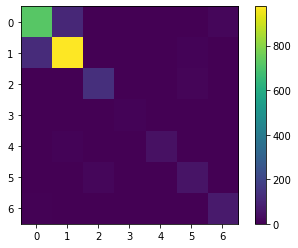

In [52]:
# TODO
pred_Y = clf.predict(test_X)
confmat = confusion_matrix(test_Y, pred_Y)
plt.imshow(confmat)
plt.colorbar()

Let try to inspect relatively

In [53]:
confmat = np.float32(confmat)

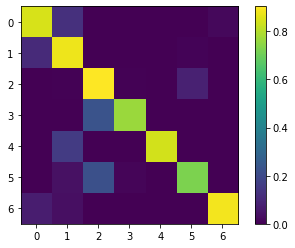

In [54]:
for i in range(len(confmat)):
    confmat[i,:] = confmat[i,:] / np.sum(confmat[i,:])
plt.imshow(confmat)
plt.colorbar()

Accuracy is limited because it does not give insights on performance. 

Let's inspect the fscore:

In [55]:
[precision, recall, _, _] = precision_recall_fscore_support(test_Y, pred_Y, average='macro')
fscore = 2 * (precision * recall) / (precision + recall)

In [56]:
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)
print('fscore:', fscore)

accuracy: 0.8648881239242685
precision: 0.8356835474456552
recall: 0.8374614062384212
fscore: 0.8365715322789625


<a name="model_selection"></a>
# Model Selection

In machine learning, we usually compare various models in order to pick the best one for a particular application.

In [57]:
from sklearn.neural_network import MLPClassifier
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Comparing model by varying parameters

In [59]:
MLPClassifier()

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

More on webpage: https://scikit-learn.org/stable/modules/neural_networks_supervised.html

<img src="assets/exerice-icon.png" style="width:80px; float:left;"></img><div style="clear:left;"></div>
**EXERCICE:** find the best MLP model in terms of `learning_rate`

In [60]:
features = dataset.data
labels = dataset.target
[X, Y] = reduce_dataset(features, labels, num_obs=1660)
idx = np.arange(len(X))
random.shuffle(idx)
X = X[idx]
Y = Y[idx]
train_X = X[:int(0.8 * len(X))]
train_Y = Y[:int(0.8 * len(Y))]
test_X = X[int(0.8 * len(X)):]
test_Y = Y[int(0.8 * len(Y)):]

for learning_rate_init in [0.1, 0.01, 0.001, 0.0001]:
    
    clf = MLPClassifier(learning_rate_init=learning_rate_init)
    clf.fit(train_X, train_Y)
    score = clf.score(test_X, test_Y)
    print(learning_rate_init, score)


0.1 0.14845094664371772
0.01 0.608433734939759
0.001 0.5972461273666093
0.0001 0.6648020654044751


## Comparing classifiers

In the context of this course, for the sake of comparison, we compare classification accuracy for two classifiers: 
- LDA: Linear Discriminant Analysis (linear model)
- kNN: k-Nearest Neigbours (non linear) 
- MLP: Multi-layer Perception (non linear)

In [61]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

<img src="assets/exerice-icon.png" style="width:80px; float:left;"></img><div style="clear:left;"></div>
**EXERCICE:** find the best classifer between `discriminant_analysis` (LDA), `neighbors` (kNN) and `MLPClassifier` (Neural Network), trained on `train_X, train_Y` and tested on `test_X, test_Y`

In [62]:
features = dataset.data
labels = dataset.target
[X, Y] = reduce_dataset(features, labels, num_obs=1660)
idx = np.arange(len(X))
random.shuffle(idx)
X = X[idx]
Y = Y[idx]
train_X = X[:int(0.8 * len(X))]
train_Y = Y[:int(0.8 * len(Y))]
test_X = X[int(0.8 * len(X)):]
test_Y = Y[int(0.8 * len(Y)):]

clf1 = LinearDiscriminantAnalysis()
clf2 = KNeighborsClassifier()
clf3 = MLPClassifier()

clf1.fit(train_X, train_Y)
clf2.fit(train_X, train_Y)
clf3.fit(train_X, train_Y)

s1 = clf1.score(test_X, test_Y)
s2 = clf2.score(test_X, test_Y)
s3 = clf3.score(test_X, test_Y)

print(s1, s2, s3)


0.6721170395869192 0.7878657487091222 0.6273666092943201


## Cross-validation

Model selection is usually done using cross-validation: a way to to create different splits of a dataset and perform several tests, one for each split. This gives a statistical estimate of the generalisability of a classifier, and can be considered as a good measure to compare models. 

There are different ways to split a dataset. Sklearn has several methods for that (see [API](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)):

Function | Description
--- | ---
`model_selection.KFold([n_splits, shuffle, ...])` | K-Folds cross-validator
`model_selection.GroupKFold([n_splits])`	| K-fold iterator variant with non-overlapping groups.
`model_selection.StratifiedKFold([n_splits, ...])`	| Stratified K-Folds cross-validator
`model_selection.LeaveOneGroupOut()`	| Leave One Group Out cross-validator
`model_selection.LeavePGroupsOut(n_groups)`	| Leave P Group(s) Out cross-validator
`model_selection.LeaveOneOut()`	| Leave-One-Out cross-validator
`model_selection.LeavePOut(p)`	| Leave-P-Out cross-validator
`model_selection.ShuffleSplit([n_splits, ...])`	| Random permutation cross-validator
`model_selection.GroupShuffleSplit([...])`	| Shuffle-Group(s)-Out cross-validation iterator
`model_selection.StratifiedShuffleSplit([...])`	| Stratified ShuffleSplit cross-validator
`model_selection.PredefinedSplit(test_fold)`	| Predefined split cross-validator
`model_selection.TimeSeriesSplit([n_splits])`	| Time Series cross-validator

A partition of the initial dataset is usually caleld a fold. In our example below, we will used the **stratified k-fold** which creates folds preserving the percentage of samples for each class.

In [64]:
from sklearn.model_selection import StratifiedKFold

Let's for instance declare a stratified spitting method with a number of splits equals to 3:

In [ ]:
splitter = StratifiedKFold( n_splits = 4 )

Reload data such having the same number of observations per class:

In [ ]:
features = dataset.data
labels = dataset.target
[features, labels] = reduce_dataset(features, labels, num_obs=1660)

In [ ]:
splitter.split(train_X, train_Y)

In [ ]:
train_index, test_index = next(splitter.split(train_X, train_Y))

In [ ]:
train_X_split = train_X[train_index]
train_Y_split = train_Y[train_index]

In [ ]:
test_X_split = train_X[test_index]
test_Y_split = train_Y[test_index]

In [ ]:
np.unique(train_Y_split)

In [ ]:
np.unique(test_Y_split)

Loop on splits:

In [ ]:
for train_index, test_index in splitter.split(train_X, train_Y):
    # Do something 
    TODO = True

## Compare models with cross-validation

In [65]:
count_tests = 0

score1 = []
score2 = []
score3 = []

splitter = StratifiedKFold( n_splits = 12 )

for train_index, test_index in splitter.split(train_X, train_Y):
    
    counter_tests+=1
    print('Split', counter_tests)

    # select training and testing datasets
    train_X_split = train_X[train_index]
    train_Y_split = train_Y[train_index]
    test_X_split = train_X[test_index]
    test_Y_split = train_Y[test_index]
    
    clf1 = LinearDiscriminantAnalysis()
    clf2 = KNeighborsClassifier()
    clf3 = MLPClassifier()

    clf1.fit(train_X, train_Y)
    clf2.fit(train_X, train_Y)
    clf3.fit(train_X, train_Y)

    s1 = clf1.score(test_X, test_Y)
    s2 = clf2.score(test_X, test_Y)
    s3 = clf3.score(test_X, test_Y)
    
    score1.append(s1)
    score2.append(s2)
    score3.append(s3)

print('LDA:', np.mean(score1))
print('kNN:', np.mean(score2))
print('MLP:', np.mean(score3))


Split
Split
Split
Split
Split
Split
Split
Split
Split
Split
Split
Split
LDA: 0.672117039586919
kNN: 0.7878657487091222
MLP: 0.5952739529546759


# Exercice

1. Load XXX dataset
2. Find the best model in terms of f-score 
3. Inspect class confusion
4. Inspect ROC curve (see Sklearn API)

In [ ]:
# TODO 1.

In [ ]:
# TODO 2.

In [ ]:
# TODO 3.

In [ ]:
# TODO 4.

___
About this material: copyright Baptiste Caramiaux (write me for any questions or use of this material [email](mailto:baptiste.caramiaux@lri.fr))
___